# Generating Synthetic Data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import beta, norm, gamma
import matplotlib.pyplot as plt

In [2]:
df_orl = pd.read_csv("data/parameter_igt_orl.csv")
df_orl["subjID_label"] = df_orl["subjID"].astype("category").cat.codes # number label for old/young
df_orl.head()

,subjID,A+,A-,K,BetaF,BetaP,A+-A-,subjID_label
0,old,0.324444,0.068862,1.502130,2.523191,-5.547480,0.255581,0
1,old,0.885744,0.120145,0.012591,3.193244,-9.159800,0.765598,0
2,old,0.318205,0.078128,1.927309,0.615708,9.272336,0.240077,0
3,old,0.728192,0.106737,0.388407,2.595746,-2.239555,0.621455,0
4,old,0.356229,0.091987,1.810674,0.508605,9.825699,0.264241,0


## Choosing the distributions

The parameters seem to follow 3 distinct distributions:  
- The [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution): Both $\beta_F$ and $\beta_P$ seem to be normally distributed. This is parameterised by the mean $\mu$ (loc) and standard deviation $\sigma$ (scale) of the data.  
Details of the functions used to model this distribution can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html).  
- The [Beta($\alpha$,$\beta$) distribution](https://en.wikipedia.org/wiki/Beta_distribution): A+ and A- are within the range [0, 1], which means we can use this distribution to model them. The beta distribution can be used to model a large variety of distributions within this range with shape parameters $\alpha$ and $\beta$.  
Details of the functions used to model the distributions can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html)  
- The [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution): Finally, the K parameter seems to roughly follow a poisson distribution which would represent the rate of decay. As the poisson distribution is only valid for integer values, we can use the gamma function as a continuous approximation. The gamma function is parameterised by shape $\alpha$ and scale $\theta$.  
Details of the functions used to model the distributions can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html)  

## Modelling a single parameter
Here we show show fitting the normal distribution works for the $\beta_P$ parameter. The plot shows the fitted distribution in orange against the real data in blue.  

In [3]:
mean, std = norm.fit(df_orl["BetaP"])
print("mean:", mean)
print("std:", std)

mean: 0.008024174333333326
std: 5.455980769684062


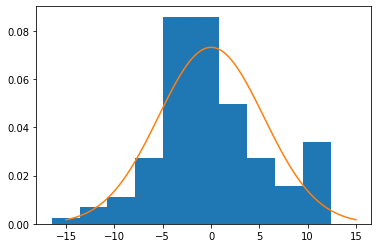

In [4]:
x = np.linspace(-15, 15, 100)
y = norm.pdf(x, mean, std)

plt.hist(df_orl["BetaP"], density=True)
plt.plot(x, y)
plt.show()

### Applying to all parameters

First we define functions to fit each of the model parameters to their distributions.

In [5]:
def fit_norm(s: pd.Series):
    loc, scale = norm.fit(s)
    return {
        "loc": loc,
        "scale": scale
    }

def fit_beta(s: pd.Series):
    a, b, loc, scale = beta.fit(s, floc=0, fscale=1)
    return {
        "a": a,
        "b": b,
        }

def fit_gamma(s: pd.Series):
    a, loc, scale = gamma.fit(s, floc=0)
    return {
        "a": a,
        "scale": scale
        }

def fit_all_params(df: pd.DataFrame):
    return {
        "A+": fit_beta(df["A+"]),
        "A-": fit_beta(df["A-"]),
        "K": fit_gamma(df["K"]),
        "BetaF": fit_norm(df["BetaF"]),
        "BetaP": fit_norm(df["BetaP"]),
    }

Then we can apply this across all of our parameters to get model each one.

In [6]:
%%capture --no-stdout --no-display
dist_params = fit_all_params(df_orl)
pd.DataFrame(dist_params)

,A+,A-,K,BetaF,BetaP
a,1.706595,2.712327,1.901708,NaN,NaN
b,4.393497,30.392386,NaN,NaN,NaN
loc,NaN,NaN,NaN,1.635854,0.008024
scale,NaN,NaN,0.434961,1.096704,5.455981


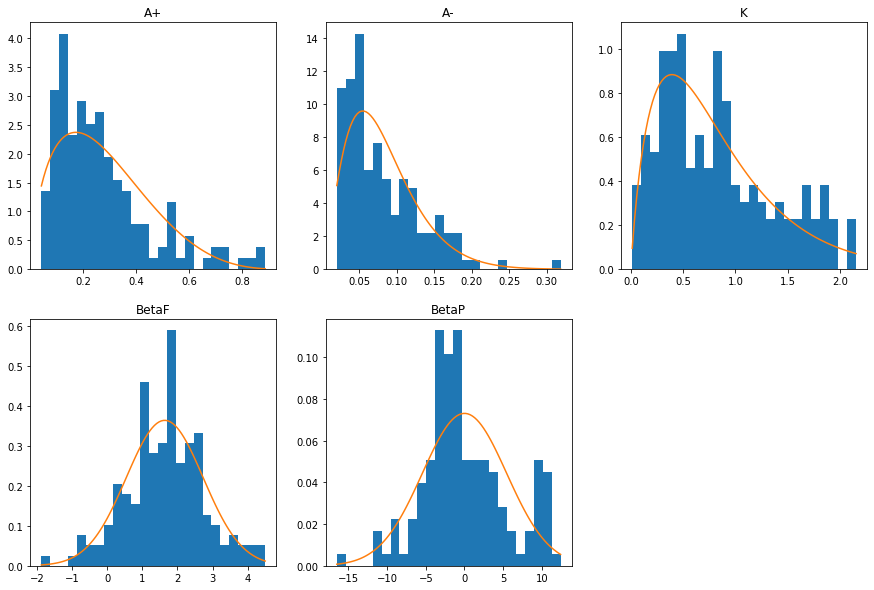

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i, (model_param, d_params) in enumerate(dist_params.items()):
    row, col = divmod(i, 3)
    
    # Generate points to draw distribution
    x = np.linspace(df_orl[model_param].min(), df_orl[model_param].max(), 100)
    if model_param in ("A+", "A-"):
        y = beta.pdf(x, **d_params)
    elif model_param == "K":
        y = gamma.pdf(x, **d_params)
    elif model_param in ("BetaF", "BetaP"):
        y = norm.pdf(x, **d_params)
        
    # Draw plots
    ax[row, col].hist(df_orl[model_param], density=True, bins=25)
    ax[row, col].plot(x, y)
    
    # Formatting
    ax[row, col].set_title(model_param)

    
# Hide unused plot
ax[1, 2].set_visible(False)

plt.show()

### Generating new data

By modelling these parameters, we can create new data by sampling from their distributions. The generated parameters could then be used to create ORL models, each representing a synthetic person.  
For now we assume that each parameter is **independent**, though this may not be the case in reality. 
Here we generate 5000 fake data points based on the entire dataset.

In [8]:
synth_data = pd.DataFrame()
for model_param, d_params in dist_params.items():
    if model_param in ("A+", "A-"):
        sample = beta.rvs(**d_params, size=5000)
    elif model_param == "K":
        sample = gamma.rvs(**d_params, size=5000)
    elif model_param in ("BetaF", "BetaP"):
        sample = norm.rvs(**d_params, size=5000)
        
    synth_data[model_param] = sample
    
synth_data.head()

,A+,A-,K,BetaF,BetaP
0,0.574094,0.031124,0.300517,3.257334,5.980216
1,0.074342,0.145210,0.258863,3.052811,-9.130873
2,0.134787,0.099285,2.055845,0.355421,0.452551
3,0.195762,0.139957,0.960942,2.175460,-3.998895
4,0.022377,0.041567,0.945053,2.423405,0.100068


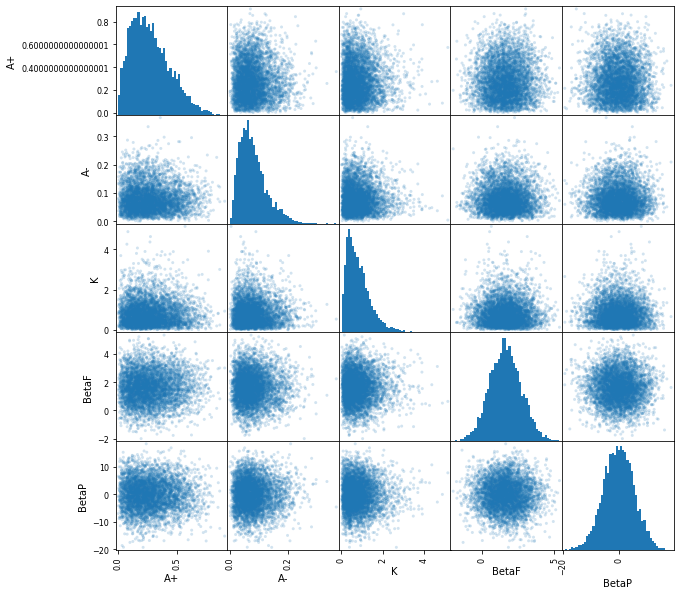

In [9]:
pd.plotting.scatter_matrix(synth_data, figsize=(10,10), hist_kwds=dict(bins=50), alpha=0.2)
plt.show()

## Modelling the smaller groups

As we saw when we explored the data and during clustering, the young and old groups differ quite a bit, so we can't really model the entire dataset with a single distribution for each parameter. We can apply the same methods to model each of these groups and generate new data for them. Here we split the old group into "Type A" (low BetaP values) and "Type B" (high BetaP values).  

### Young

In [10]:
%%capture --no-stdout --no-display

df_orl_young = df_orl[df_orl["subjID"] == "young"]
dist_params_young = fit_all_params(df_orl_young)
pd.DataFrame(dist_params_young)

,A+,A-,K,BetaF,BetaP
a,3.655719,2.989598,3.477007,NaN,NaN
b,14.445001,36.231395,NaN,NaN,NaN
loc,NaN,NaN,NaN,1.552756,-0.767603
scale,NaN,NaN,0.177327,1.077317,3.056362


### Old

In [11]:
%%capture --no-stdout --no-display

df_orl_old = df_orl[df_orl["subjID"] == "old"]
dist_params_old = fit_all_params(df_orl_old)
pd.DataFrame(dist_params_old)

,A+,A-,K,BetaF,BetaP
a,1.538382,2.499188,1.502358,NaN,NaN
b,2.583400,25.265530,NaN,NaN,NaN
loc,NaN,NaN,NaN,1.754565,1.116063
scale,NaN,NaN,0.750838,1.113110,7.540629


In [12]:
beta_p_split = 7

#### Type A

In [13]:
%%capture --no-stdout --no-display

df_orl_old_a = df_orl[(df_orl["subjID"] == "old") & (df_orl["BetaP"] <= beta_p_split)]
dist_params_old_a = fit_all_params(df_orl_old_a)
pd.DataFrame(dist_params_old_a)

,A+,A-,K,BetaF,BetaP
a,1.423581,2.785678,1.161286,NaN,NaN
b,2.106115,30.929010,NaN,NaN,NaN
loc,NaN,NaN,NaN,2.191551,-3.315467
scale,NaN,NaN,0.785322,0.947348,5.082615


#### Type B

In [14]:
%%capture --no-stdout --no-display

df_orl_old_b = df_orl[(df_orl["subjID"] == "old") & (df_orl["BetaP"] > beta_p_split)]
dist_params_old_b = fit_all_params(df_orl_old_b)
pd.DataFrame(dist_params_old_b)

,A+,A-,K,BetaF,BetaP
a,2.318003,2.263055,18.985592,NaN,NaN
b,5.303646,19.375619,NaN,NaN,NaN
loc,NaN,NaN,NaN,0.880591,9.979123
scale,NaN,NaN,0.082174,0.881113,1.042388


## Results

In [15]:
# Function to draw row of plots
def draw_dist_fit(dist_params, data_df, ax_row, y_label):
    for i, (model_param, d_params) in enumerate(dist_params.items()):
        row, col = divmod(i, 3)
    
        # Generate points to draw beta
        x = np.linspace(data_df[model_param].min(), data_df[model_param].max(), 100)[1:-1]
        if model_param in ("A+", "A-"):
            y = beta.pdf(x, **d_params)
        elif model_param == "K":
            y = gamma.pdf(x, **d_params)
        elif model_param in ("BetaF", "BetaP"):
            y = norm.pdf(x, **d_params)
        
        
        # Draw plots
        ax_row[i].hist(data_df[model_param], density=True, bins=25)
        ax_row[i].plot(x, y)
        
    ax_row[0].set_ylabel(y_label)

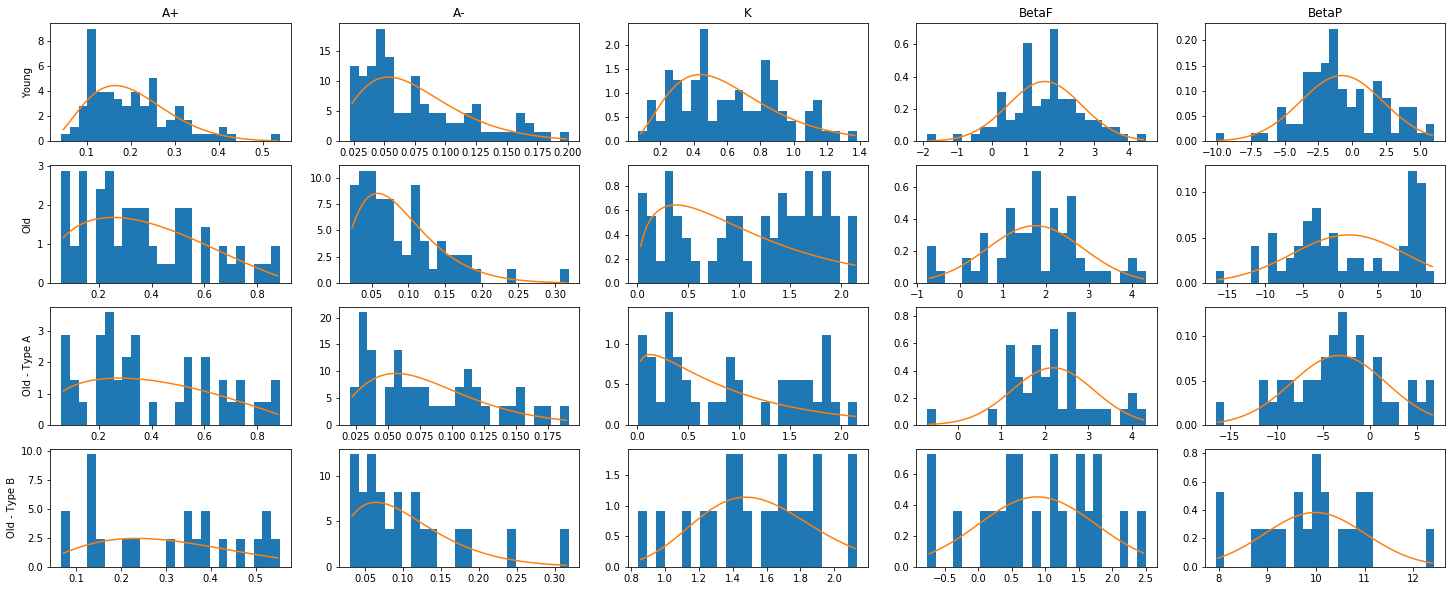

In [16]:
fig, ax = plt.subplots(4, 5, figsize=(25, 10))

# Plots
draw_dist_fit(dist_params_young, df_orl_young, ax[0], "Young")
draw_dist_fit(dist_params_old, df_orl_old, ax[1], "Old")
draw_dist_fit(dist_params_old_a, df_orl_old_a, ax[2], "Old - Type A")
draw_dist_fit(dist_params_old_b, df_orl_old_b, ax[3], "Old - Type B")

# Param titles
for i, param in enumerate(dist_params_old_b):
    ax[0, i].set_title(param)
    
plt.show()

This lets us compare the parameters across each of the different groups. We can see that the A+ and A- parameters are fairly similar for all of the groups, spread out with a slight skew to the left.  
The K parameter shows a difference between young and old, concentrated centrally versus much more uniform. There is a large variety in the distributions across groups, so the gamma distribution struggles to fit these well. More data may be needed in this case to start being able to see the underlying distributions.  
The $\beta_F$ parameter is normally distributed for both the young and old (type A) groups, however with the type B group we see a degredation in the normal shape, being much closer to a uniform distribution.  
Finally the $\beta_P$ parameter clearly shows the three distinct normal distributions. Notably the type B group has much higher values than both the young and type A groups which have similar distributions. In [Bechara, et al. (1997)](http://www.labsi.org/cognitive/Becharaetal1997.pdf), they note that participants with damage to their prefrontal cortex continue to choose bad decks even in the face of punishing outcomes, so the high value of perserverance for this group could be explained by this.  

### Putting the groups back together
Finally we can put all of this together to model the entire dataset. We generate new samples for each group in proportion to their representation in the entire dataset.  

In [17]:
groups = ["young", "old - type A", "old - type B"]
dist_params_list = [dist_params_young, dist_params_old_a, dist_params_old_b]
group_sizes = [len(df) for df in [df_orl_young, df_orl_old_a, df_orl_old_b]]

synth_dataframes = []
for group, dist_params, size in zip(groups, dist_params_list, group_sizes):
    synth_single = pd.DataFrame()
    for model_param, d_param in dist_params.items():
        # Sample data from distribution
        if model_param in ("A+", "A-"):
            sample = beta.rvs(**d_param, size=size * 100)
        elif model_param == "K":
            sample = gamma.rvs(**d_param, size=size * 100)
        elif model_param in ("BetaF", "BetaP"):
            sample = norm.rvs(**d_param, size=size * 100)
        
        synth_single[model_param] = sample
        
    synth_single["group"] = group
    synth_dataframes.append(synth_single)
        
synth_df = pd.concat(synth_dataframes)
synth_df["group_label"] = synth_df["group"].astype("category").cat.codes  # Add group label
synth_df.sample(10)

,A+,A-,K,BetaF,BetaP,group,group_label
3930,0.492407,0.047245,2.498637,2.795654,-10.344888,old - type A,0
6409,0.404574,0.186659,0.306398,2.496660,3.049128,young,2
4854,0.070355,0.054698,0.693009,2.515573,0.764829,young,2
1537,0.070397,0.217467,1.302696,2.144539,10.051517,old - type B,1
1061,0.339078,0.085428,0.329380,1.196937,0.480336,young,2
1669,0.368196,0.067196,1.225827,1.474769,2.245432,young,2
1237,0.262965,0.043771,1.343233,-1.508035,1.039165,young,2
6855,0.114716,0.025715,0.517140,3.408465,-0.031315,young,2
1293,0.111152,0.096714,1.367111,1.193835,11.473153,old - type B,1
2375,0.347549,0.151705,0.162484,1.213896,6.768393,young,2


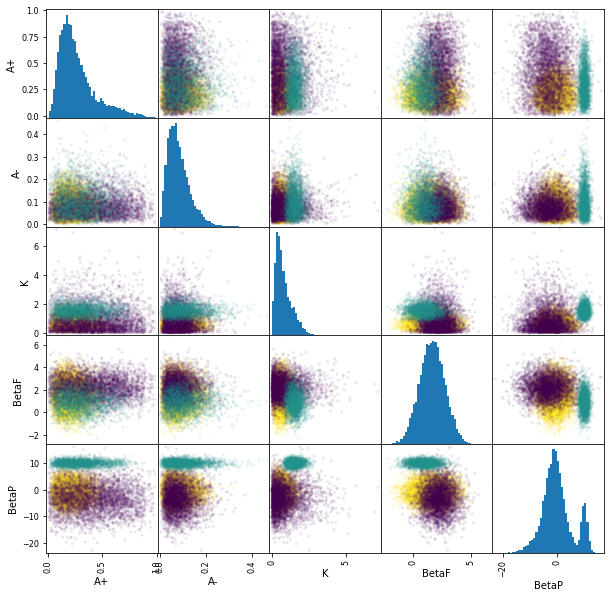

In [18]:
pd.plotting.scatter_matrix(synth_df.drop(columns="group_label"), figsize=(10,10), hist_kwds=dict(bins=50), alpha=0.1, c=synth_df["group_label"])
plt.show()